VDSR for DEM processing - Filter 4*4
====================================
Very Deep Super Resolution (VDSR) CNN based on the implementation of George Seif [GitHub](https://github.com/GeorgeSeif/VDSR-Keras).
Thanks to [Zushicat](https://github.com/zushicat) for the support.

An implementation of the Super Resolution CNN proposed in:

[Kim, Jiwon, Jung Kwon Lee, and Kyoung Mu Lee. "Accurate image super-resolution using very deep convolutional networks." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016.](https://arxiv.org/abs/1511.04587)

This Notebook is running on Google Colab with data storage on Google Drive. Of course this could be adapted to local resources.


In [2]:
import os
# connect with google drive  
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Training
--------
**This part could be skipped if you like to use the prepared weights.**

Download the training, test and validation data of the austrian DTM [here](https://www.openmaps.online/data/austria_dtm.zip). License: Data by - Geoland.at (2019) - CC BY 4.0 (CC BY 4.0)

When using own data, make sure that the low resolution images are upsampled to 300*300 px. Input size for both datasets must be 300 * 300 px for this CNN.

Get rasterio for GeoTiff processing

In [ ]:
!pip install rasterio

In [ ]:
import os
import tensorflow as tf
import numpy as np
import rasterio
from tensorflow.python.data.experimental import AUTOTUNE
from rasterio.plot import reshape_as_image, reshape_as_raster, show
import re

# adapt your paths
HR_PATH_TRAIN = "/content/drive/My Drive/vdsr4dem/hr_train"
LR_PATH_TRAIN = "/content/drive/My Drive/vdsr4dem/lr_train"
HR_PATH_VAL = "/content/drive/My Drive/vdsr4dem/hr_valid"
LR_PATH_VAL = "/content/drive/My Drive/vdsr4dem/lr_valid"

# maximal and minimal values of the whole trainings dataset
ds_max = 3150
ds_min = 170

# use human sorting to avoid problems with the order of the files for training and validation
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def _images_dataset(image_files):    
    listAll = []
    for img in image_files:
        with rasterio.open(img) as src:
            array = src.read(
                out_shape=(
                    src.count,
                    int(src.height),
                    int(src.width)
                )
            )
            array = reshape_as_image(array)            
            lr = (array - ds_min) / (ds_max - ds_min)
            listAll.append(lr)        
    ds = tf.data.Dataset.from_tensor_slices(listAll)
    #print(ds)
    return ds

def _get_dataset(path, num_images):
    file_names = [f"{path}/{x}" for x in os.listdir(path) if x.find(".tif") != -1]
    if num_images is not None:
        file_names = file_names[:num_images]
    print("--->", len(file_names))
    file_names.sort(key=natural_keys)
    print(file_names)
    ds = _images_dataset(file_names)    
    return ds


def dataset(batch_size=16, repeat_count=None, random_transform=True, use_set="train", num_images=None):
    print(num_images)
    if use_set == "train":
        print('LR_PATH_TRAIN')
        lr_ds = _get_dataset(LR_PATH_TRAIN, num_images)
        print('HR_PATH_TRAIN')
        hr_ds = _get_dataset(HR_PATH_TRAIN, num_images)
    elif use_set == "val":
        print('LR_PATH_VAL')
        lr_ds = _get_dataset(LR_PATH_VAL, num_images)
        print('HR_PATH_VAL')
        hr_ds = _get_dataset(HR_PATH_VAL, num_images)
    else:
        return None
    
    ds = tf.data.Dataset.zip((lr_ds, hr_ds))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

if __name__ == "__main__":
    # To avoid problems with the order of the files always set num_images to the real number of images in the folder!
    train_ds = dataset(batch_size=16, use_set="train", num_images=30)
    val_ds = dataset(batch_size=1, use_set="val", num_images=30)
    print("done all")

VDSR Model Filter Kernel 4*4 , 20 Conv2D layers

In [35]:
from keras import Sequential
from keras.layers import Conv2D
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, add
from keras import optimizers
from keras import losses
from keras.optimizers import Adam
import tensorflow as tf

IMG_SIZE = (300, 300, 1)

model = Sequential()

input_img = Input(shape=IMG_SIZE)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(input_img)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(1, (4, 4), padding='same', kernel_initializer='he_normal')(model)

res_img = model

output_img = add([res_img, input_img])

model = Model(input_img, output_img)

adam = Adam(lr=0.00001)
model.compile(adam, loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

Fit the Model

In [ ]:
from keras.callbacks import ModelCheckpoint

# adapt path
checkpoint = ModelCheckpoint("/content/drive/My Drive/vdsr4dem/weights/vdsr4dem_4_new.h5", monitor='loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=True)
# adapt epochs
model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[checkpoint])

Visualization of the loss

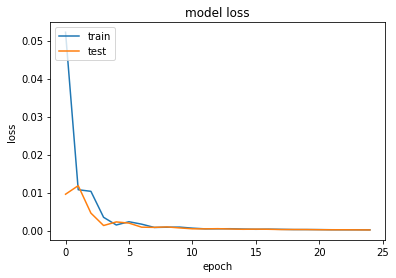

In [37]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Visualization of the mean absolute error

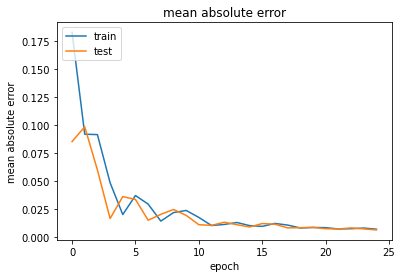

In [38]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['mean_absolute_error'])
plt.plot(model.history.history['val_mean_absolute_error'])
plt.title('mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Processing
--------

VDSR Model Filter Kernel 4*4 , 20 Conv2D layers

The landscape of the test area (Austria) is formed by fluvial and glacial erosion. Thus the model may not fit to other landscapes.



**Skip the next step when training was applied before!**

In [3]:
from keras import Sequential
from keras.layers import Conv2D
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, add
from keras import optimizers
from keras import losses
from keras.optimizers import Adam
import tensorflow as tf

IMG_SIZE = (300, 300, 1)

model = Sequential()

input_img = Input(shape=IMG_SIZE)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(input_img)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)

model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(64, (4, 4), padding='same', kernel_initializer='he_normal')(model)
model = Activation('relu')(model)
model = Conv2D(1, (4, 4), padding='same', kernel_initializer='he_normal')(model)

res_img = model

output_img = add([res_img, input_img])

model = Model(input_img, output_img)

adam = Adam(lr=0.00001)
model.compile(adam, loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# adapt path
model.load_weights('/content/drive/My Drive/vdsr4dem/weights/vdsr4dem_4.h5')

Read all GeoTiffs from folder and process 

Skip the next step if rasterio is allready installed

In [ ]:
!pip install rasterio

In [9]:
import os
import sys
import numpy as np
import rasterio
from tensorflow.python.data.experimental import AUTOTUNE
from rasterio.plot import reshape_as_image, reshape_as_raster, show

# adapt paths
path = '/content/drive/My Drive/vdsr4dem/lr_test'
path_out = '/content/drive/My Drive/vdsr4dem/sr_images'

for file in os.listdir(path):
    current = os.path.join(path, file)
    print(current)
    x, y = [], []
    with rasterio.open(current) as src:
        array = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )
        profile = src.profile                
    out_profile = src.profile.copy()
    max_val = np.amax(array)
    min_val = np.amin(array)
    array = reshape_as_image(array)
    lr = (array - min_val) / (max_val - min_val)
    x = np.expand_dims(lr, axis=0)
    out_array = model.predict(x)
    srA = out_array
    srA = srA * (max_val - min_val) + min_val
    srA = np.squeeze(srA, axis=0)
    #print(srA.shape)
    print ("sr :", srA.dtype, " shape ", srA.shape)
    current_out = os.path.join(path_out, file)
    with rasterio.open(current_out, 'w', **out_profile) as dst:
        dst.write(reshape_as_raster(srA))
print("finished")

/content/drive/My Drive/vdsr4dem/lr_test/280020_377420.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/277020_366710.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/286740_368210.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/285840_357620.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/279900_371660.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/280920_366440.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/291690_365510.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/289290_376880.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/284910_361910.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/296490_366140.tif
sr : float32  shape  (300, 300, 1)
/content/drive/My Drive/vdsr4dem/lr_test/296790_371270.tif
s

Statistics with test dataset
--------------------------------------


Skip the next step if rasterio is allready installed

In [4]:
!pip install rasterio

     |████████████████████████████████| 18.3MB 261kB/s 


In [7]:
import os
import sys
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from keras.preprocessing.image import save_img
import rasterio
from tensorflow.python.data.experimental import AUTOTUNE
from rasterio.plot import reshape_as_image, reshape_as_raster, show
from rasterio import Affine
from rasterio.enums import Resampling
from numpy import savetxt

# adapt paths
path_lr = '/content/drive/My Drive/vdsr4dem/lr_test'
path_hr = '/content/drive/My Drive/vdsr4dem/hr_test'

meanAbsoluteError = []
meanAbsoluteErrorCubic = []

countMAE = 0
countRMSE = 0
countPSNR = 0
countSSI = 0
countMAESlice = 0
countRMSESlice = 0
countPSNRSlice = 0
countSSISlice = 0
totalMAE_lr = 0
totalMAE_sr = 0
totalRMSE_lr = 0
totalRMSE_sr = 0
totalMAX_lr = 0
totalMAX_sr = 0
fileCounter = 0 

# read low resolution images
for file in os.listdir(path_lr):
    current = os.path.join(path_lr, file)
    fileCounter += 1;
    x, y = [], []
    with rasterio.open(current) as src:
        arrayLR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )        
    max_val_lr = np.amax(arrayLR)
    min_val_lr = np.amin(arrayLR)
    arrayLR = reshape_as_image(arrayLR)
    nsamples, nx, ny = arrayLR.shape
    arrayLR = arrayLR.reshape((nsamples,nx*ny))
        
    # process super resolution image
    # normalize
    lr4sr = (arrayLR - min_val_lr) / (max_val_lr - min_val_lr)
    lr4sr = np.expand_dims(lr4sr, axis=0)
    arraySR = model.predict(lr4sr)
    # recalculate real world values for sr image
    arraySR = arraySR * (max_val_lr - min_val_lr) + min_val_lr
    arraySR = np.squeeze(arraySR, axis=0)
    nsamples, nx, ny = arraySR.shape
    arraySR = arraySR.reshape((nsamples,nx*ny))

    # maximal value of sr image    
    max_val_sr = np.amax(arraySR)

    # load hr image to compare images    
    currentHr = os.path.join(path_hr, file)
    with rasterio.open(currentHr) as src:
        arrayHR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )
 
    arrayHR = reshape_as_image(arrayHR)

    nsamples, nx, ny = arrayHR.shape
    arrayHR = arrayHR.reshape((nsamples,nx*ny))

    # slice 15 pixels from border because border effects
    slice_val = 15
    HrSlice = arrayHR[slice_val:-slice_val, slice_val:-slice_val]
    SrSlice = arraySR[slice_val:-slice_val, slice_val:-slice_val]
    LrSlice = arrayLR[slice_val:-slice_val, slice_val:-slice_val]
    
    # calculate the metrics for sr image
    MAE_sr = mean_absolute_error(arrayHR, arraySR)
    RMSE_sr = mean_squared_error(arrayHR, arraySR, squared=False)
    SSI_sr = structural_similarity(arrayHR, arraySR)
    MAE_sr_slice = mean_absolute_error(HrSlice, SrSlice)
    RMSE_sr_slice = mean_squared_error(HrSlice, SrSlice, squared=False)
    SSI_sr_slice = structural_similarity(HrSlice, SrSlice)
    MAX_sr = np.amax(abs(arrayHR - arraySR))
    MAX_sr_slice = np.amax(abs(HrSlice - SrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_sr = peak_signal_noise_ratio(arrayHR, arraySR, data_range=3150)
    PSNR_sr_slice = peak_signal_noise_ratio(HrSlice, SrSlice, data_range=3150)
    
    # calculate the metrics for lr image
    MAE_lr = mean_absolute_error(arrayHR, arrayLR)
    RMSE_lr = mean_squared_error(arrayHR, arrayLR, squared=False)
    SSI_lr = structural_similarity(arrayHR, arrayLR)
    MAE_lr_slice = mean_absolute_error(HrSlice, LrSlice)
    RMSE_lr_slice = mean_squared_error(HrSlice, LrSlice, squared=False)
    SSI_lr_slice = structural_similarity(HrSlice, LrSlice)
    MAX_lr = np.amax(abs(arrayHR - arrayLR))
    MAX_lr_slice = np.amax(abs(HrSlice - LrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_lr = peak_signal_noise_ratio(arrayHR, arrayLR, data_range=3150)
    PSNR_lr_slice = peak_signal_noise_ratio(HrSlice, LrSlice, data_range=3150)
    
    # MAE count improved images
    if MAE_sr < MAE_lr:
        countMAE += 1
    if MAE_sr_slice < MAE_lr_slice:
        countMAESlice += 1    
    # RMSE count improved images
    if RMSE_sr < RMSE_lr:
        countRMSE += 1
    if RMSE_sr_slice < RMSE_lr_slice:
        countRMSESlice += 1 
    # PSNR count imporved images, higher values are better
    if PSNR_sr > PSNR_lr:
        countPSNR += 1
    if PSNR_sr_slice > PSNR_lr_slice:
        countPSNRSlice += 1    
    # SSI count imporved images, higher values are better
    if SSI_sr > SSI_lr:
        countSSI += 1
    if SSI_sr_slice > SSI_lr_slice:
        countSSISlice += 1

    totalMAE_lr = totalMAE_lr + MAE_lr_slice
    totalMAE_sr = totalMAE_sr + MAE_sr_slice
    totalRMSE_lr = totalRMSE_lr + RMSE_lr_slice
    totalRMSE_sr = totalRMSE_sr + RMSE_sr_slice        
    totalMAX_lr = totalMAX_lr + MAX_lr_slice
    totalMAX_sr = totalMAX_sr + MAX_sr_slice 

    # print metrics for every tile if desired
    #print(file ,' SR MaxError: ', MAX_sr_slice  ,' LR MaxError: ', MAX_lr_slice, ' Difference MaxError LR - SR: ', MAX_lr_slice - MAX_sr_slice)
    #print(file ,' SR MAE: ', MAE_sr_slice ,' LR MAE: ', MAE_lr_slice, ' Difference LR - SR: ', MAE_lr_slice - MAE_sr_slice)
    #print(file ,' SR RMSE: ', RMSE_sr_slice ,' LR RMSE: ', RMSE_lr_slice, ' Difference LR - SR: ', RMSE_lr_slice - RMSE_sr_slice)
    #print(file ,' SR PSNR: ', PSNR_sr_slice ,' LR PSNR: ', PSNR_lr_slice, ' Difference LR - SR: ', PSNR_lr_slice - PSNR_sr_slice)

print('Better results of',fileCounter,'test areas for MAE        ',countMAE)
print('Better results of',fileCounter,'test areas for MAE sliced ',countMAESlice)
print('Better results of',fileCounter,'test areas for RMSE       ',countRMSE)
print('Better results of',fileCounter,'test areas for RMSE sliced',countRMSESlice)
print('Better results of',fileCounter,'test areas for PNSR       ',countPSNR)
print('Better results of',fileCounter,'test areas for PNSR sliced',countPSNRSlice)
print('Better results of',fileCounter,'test areas for SSI        ',countSSI)
print('Better results of',fileCounter,'test areas for SSI sliced ',countSSISlice)

print('Mean MAE LR', totalMAE_lr/fileCounter);
print('Mean MAE SR', totalMAE_sr/fileCounter);
print('Difference LR - SR MAE ', totalMAE_lr/fileCounter - totalMAE_sr/fileCounter)
print('Mean RMSE LR', totalRMSE_lr/fileCounter);
print('Mean RMSE SR', totalRMSE_sr/fileCounter);
print('Difference SR - LR RMSE ', totalRMSE_lr/fileCounter - totalRMSE_sr/fileCounter)
print('MAX LR', totalMAX_lr/fileCounter);
print('MAX SR', totalMAX_sr/fileCounter);
print('Difference LR - SR MAX ', totalMAX_lr/fileCounter - totalMAX_sr/fileCounter)

Better results of 30 test areas for MAE         29
Better results of 30 test areas for MAE sliced  17
Better results of 30 test areas for RMSE        30
Better results of 30 test areas for RMSE sliced 30
Better results of 30 test areas for PNSR        30
Better results of 30 test areas for PNSR sliced 30
Better results of 30 test areas for SSI         23
Better results of 30 test areas for SSI sliced  23
Mean MAE LR 0.855532372991244
Mean MAE SR 0.8560128390789032
Difference LR - SR MAE  -0.00048046608765928145
Mean RMSE LR 1.480201146999995
Mean RMSE SR 1.4499177038669586
Difference SR - LR RMSE  0.030283443133036325
MAX LR 24.78179931640625
MAX SR 24.43216349283854
Difference LR - SR MAX  0.3496358235677093
30
